In [10]:
from pathlib import Path
import re
import csv

import requests
import pandas as pd
import plotly.express as px


In [11]:
from mp_data import get_grade, get_subgrade, get_first_sends
from mp_data import mpl_hist, px_hist


In [12]:
BEN_THORNTON_URL = 'https://www.mountainproject.com/user/112795239/ben-thornton/tick-export'


In [13]:
# Read in the data from mountain project
df = pd.DataFrame(csv.reader(requests.get(BEN_THORNTON_URL).text.splitlines()))

# Set the first line as the header
df = df.set_axis(df.iloc[0], axis=1).iloc[1:]                

# Tweak the data
df = (df
      .assign(**{'Grade': df['Rating'].apply(get_grade)})                                 # Get the number grade (e.g. 11)
      .assign(**{'Subgrade': df['Rating'].apply(get_subgrade)})                           # Get the letter grade (e.g. a)
      .assign(**{'Date': pd.to_datetime(df['Date'])})                                     # Get the year of the send
      .assign(**{'Style': df['Style'].str.lower()})                                       # Change values to lowercase     
      .assign(**{'Lead Style': df['Lead Style'].str.lower()})                             # Change values to lowercase
      .assign(**{'Route Type': df['Route Type'].str.lower()})                             # Change values to lowercase 
      [['Date', 'Route', 'Style', 'Lead Style', 'Route Type', 'Grade', 'Subgrade']])      # Keep only certain columns


In [5]:
df


,Date,Route,Style,Lead Style,Route Type,Grade,Subgrade
1,2023-11-22,Cell Block Six,lead,fell/hung,sport,12,c
2,2023-11-22,Cell Block Six,lead,fell/hung,sport,12,c
3,2023-11-22,Cell Block Six,lead,fell/hung,sport,12,c
4,2023-11-19,Cell Block Six,lead,fell/hung,sport,12,c
5,2023-11-19,Cell Block Six,lead,fell/hung,sport,12,c
...,...,...,...,...,...,...,...
547,2017-08-27,Biohazard,tr,,trad,10,a
548,2017-08-26,Team Jesus,tr,,trad,10,a
549,2017-08-26,New River Gunks,follow,,"trad, tr",7,+
550,2017-04-02,Surly Girl,,,tr,8,None


In [6]:
df_firsts = get_first_sends(df, 'sport').sort_values('Date', ascending=False)
df_firsts = df_firsts.assign(Year=df_firsts.Date.dt.year)


In [7]:
df_firsts.sort_values(['Year', 'Grade'], ascending=False).head(20)


,Date,Route,Style,Lead Style,Route Type,Grade,Subgrade,Year
16,2023-11-07,Wild Yet Tasty,lead,redpoint,sport,12,a,2023
36,2023-10-16,Last Rites,lead,redpoint,sport,12,b,2023
45,2023-10-11,Mosaic,lead,redpoint,sport,12,c,2023
52,2023-10-07,Sex Farm,lead,redpoint,sport,12,b,2023
57,2023-09-25,Mercy the Huff,lead,redpoint,sport,12,b,2023
7,2023-11-12,Tea at the Palaz of Hoon,lead,flash,sport,11,b,2023
8,2023-11-12,A Portrait of the Artist as a Young Man,lead,flash,sport,11,b,2023
14,2023-11-11,Mona Lisa Overdrive,lead,flash,sport,11,b,2023
23,2023-11-01,Snozzberries,lead,flash,sport,11,d,2023
41,2023-10-14,On Bended Knee,lead,redpoint,sport,11,a,2023


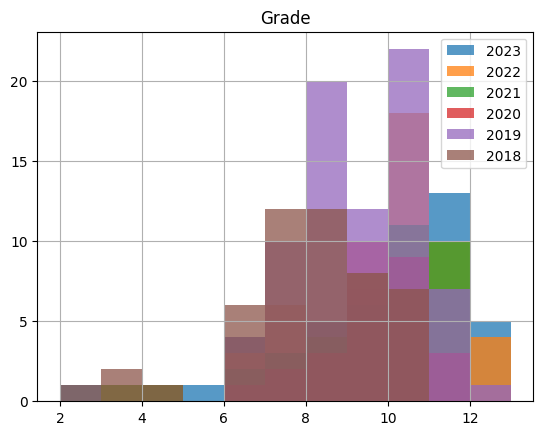

In [8]:
ax = mpl_hist(df)


In [9]:
px_hist(df)


In [10]:
from mp_data import px_hist_3d
import plotly.graph_objects as go


In [11]:
df_firsts = get_first_sends(df)
df_firsts['Year'] = df_firsts['Date'].dt.year
hist_data = (df_firsts
             .groupby(['Year', 'Grade'])['Route']
             .count()
             .sort_index(ascending=False)
             .to_frame()
             .reset_index()
             .rename(columns={'Route': 'Count'})
             .pivot_table('Count', 'Year', 'Grade')
             .fillna(0))

hist_data


Grade,2,3,4,6,7,8,9,10,11,12
Year,,,,,,,,,,
2018,1.0,2.0,1.0,6.0,12.0,12.0,8.0,7.0,0.0,0.0
2019,0.0,0.0,0.0,4.0,10.0,20.0,12.0,22.0,7.0,1.0
2020,0.0,0.0,0.0,1.0,2.0,3.0,10.0,9.0,3.0,0.0
2021,0.0,1.0,1.0,3.0,3.0,4.0,6.0,11.0,10.0,0.0
2022,0.0,1.0,1.0,3.0,6.0,3.0,9.0,17.0,10.0,4.0
2023,0.0,0.0,0.0,3.0,3.0,5.0,7.0,8.0,9.0,4.0


In [12]:
import numpy as np


In [13]:
hist_data.columns.max()


12

In [14]:
hist_data.columns.max()


12

In [15]:
hist_data


Grade,2,3,4,6,7,8,9,10,11,12
Year,,,,,,,,,,
2018,1.0,2.0,1.0,6.0,12.0,12.0,8.0,7.0,0.0,0.0
2019,0.0,0.0,0.0,4.0,10.0,20.0,12.0,22.0,7.0,1.0
2020,0.0,0.0,0.0,1.0,2.0,3.0,10.0,9.0,3.0,0.0
2021,0.0,1.0,1.0,3.0,3.0,4.0,6.0,11.0,10.0,0.0
2022,0.0,1.0,1.0,3.0,6.0,3.0,9.0,17.0,10.0,4.0
2023,0.0,0.0,0.0,3.0,3.0,5.0,7.0,8.0,9.0,4.0


In [16]:
z = hist_data.values
sh_0, sh_1 = z.shape
x = np.linspace(hist_data.index.min(), hist_data.index.max(), sh_0, endpoint=True)
y = np.linspace(hist_data.columns.min(), hist_data.columns.max(), sh_1, endpoint=True)
fig = go.Figure(data=[go.Surface(z=hist_data.values, x=x, y=y)])

fig.update_layout(title='Sends', scene=dict(
    xaxis=dict(
        range=[min(x), max(x)],
        nticks = len(x),
        title='Year',
    ),
    yaxis=dict(
        range=[min(y), max(y)],
        nticks = len(y),
        title='Grade',
    ),
    zaxis=dict(
        # range=[hist_data.values.min(), hist_data.values.max()],
        # nticks = len(y),
        # title='Grade',
    ),
))
fig.show()                                    


In [17]:
pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv')


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,0,27.809850,49.619360,83.080670,116.66320,130.41400,150.72060,220.18710,156.15360,148.64160,...,49.961420,21.89279,17.025520,11.743170,14.752260,13.667100,5.677561,3.312340,1.156517,-0.147662
1,1,27.719660,48.550220,65.213740,95.27666,116.99640,133.90560,152.34120,151.93400,160.11390,...,33.088710,38.40972,44.248430,69.578600,4.019351,3.050024,3.039719,2.996142,2.967954,1.999594
2,2,30.426700,33.477520,44.809530,62.47495,77.43523,104.21530,102.73930,137.00040,186.07060,...,48.471320,74.71461,60.090900,7.073525,6.089851,6.537450,6.666096,7.306965,5.736840,3.625628
3,3,16.665490,30.108600,39.969520,44.12225,59.57512,77.56929,106.89250,166.55390,175.23810,...,60.559160,55.92124,15.172840,8.248324,36.680870,61.934130,20.268670,68.588190,46.498120,0.236010
4,4,8.815617,18.351600,8.658275,27.58590,48.62691,60.18013,91.32860,145.71090,116.06530,...,47.426910,69.20731,44.954680,29.171970,17.916740,16.255150,14.655590,17.260480,31.222450,46.717040
5,5,6.628881,10.413390,24.819390,26.08952,30.16050,52.30802,64.71007,76.30823,84.63686,...,140.264700,81.26501,56.457560,30.421640,17.287820,8.302431,2.981626,2.698536,5.886086,5.268358
6,6,21.839750,6.639270,18.970850,32.89204,43.15014,62.86014,104.66570,130.22940,114.84940,...,122.422100,123.96980,109.095200,98.419560,77.613740,32.490310,14.673440,7.370775,0.037110,0.642339
7,7,53.343030,26.797970,6.639270,10.88787,17.20440,56.18116,79.70141,90.84530,98.27675,...,68.174900,46.24076,39.938570,31.216530,36.883350,40.025250,117.429700,12.703280,1.729771,0.000000
8,8,25.667850,63.057170,22.141400,17.07400,41.74483,60.27227,81.42432,114.44400,102.32340,...,59.193550,42.47175,14.635980,6.944074,6.944075,27.749360,0.000000,0.000000,0.094494,0.077323
9,9,12.827000,69.205540,46.762930,13.96517,33.88744,61.82613,84.74799,121.12200,145.27410,...,79.344250,25.93483,6.944074,6.944074,6.944075,7.553681,0.000000,0.000000,0.000000,0.000000
